# Practica 1 - Sensado y Análisis de Audio

## Ciencia de Datos para Sensores Inteligentes, Maestría en Ciencias de la Computación, CICESE

### Francisco Regalado

31 de enero del 2025

---
#### Introducción
En esta practica, se plantea una alternativa al registro de asistencia en papel o con QR para el registro de entrada y salida en el departamento de Ciencias Computacionales. La alternativa propuesta es por medio de renocimiento por voz.

El dataset consiste en la recopilación de audio de 29 personas diciendoosla 3 frases: (i) "confirmando mi asistencia", (ii) "asistencia de {nombre de persona}" y (iii) una frase libre. Cada frase se menciona 5 veces dando un total de 435 audios en el dataset.

---

### 1. Importamos las librerías necesarias

In [2]:
import os
import librosa
import numpy as np
import soundfile as sf
from pydub import AudioSegment
from tqdm import tqdm
import noisereduce as nr

### 2. Procesamiento de audio

#### 2.1 Cambiamos el formato de los audios a .wav

In [6]:
# Configuración para el procesamiento de audio
INPUT_FOLDER = "/Users/paco/Documents/GitHub/CDSI_2025/Practicas/Practica-1_SensadoDeVoz/Audios"
OUTPUT_FOLDER = "audios_procesados"
AUGMENTED_FOLDER = "audios_aumentados"
OUTPUT_FOLDER = "audios_procesados"
CLEANED_FOLDER = "audios_limpiados"
AUGMENTED_FOLDER = "audios_aumentados"

In [8]:
# Creamoslas carpertas para guardar los audios con el cambio de formato
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(CLEANED_FOLDER, exist_ok=True)
os.makedirs(AUGMENTED_FOLDER, exist_ok=True)

In [10]:
# Conversión a WAV
def convert_to_wav(input_folder, output_folder):
    for file in tqdm(os.listdir(input_folder), desc="Convirtiendo audios a WAV"):
        if file.endswith((".mp3", ".ogg", ".flac", ".aac", ".m4a")):
            audio = AudioSegment.from_file(os.path.join(input_folder, file))
            wav_path = os.path.join(output_folder, os.path.splitext(file)[0] + ".wav")
            audio.export(wav_path, format="wav")

In [12]:
# Llamamos a función para cambiar el formato
convert_to_wav(INPUT_FOLDER, OUTPUT_FOLDER)

Convirtiendo audios a WAV: 100%|██████████| 376/376 [00:20<00:00, 18.00it/s]


#### 2.2 Limpieza de audio
En esta sección se aplicara una limpieza de audio. Se eliminaran los silencios iniciales y finales, se reducira el ruido ambiental además de una normalización en el volumen de los audios. 

In [15]:
TOP_DB = 20  # Umbral de silencio en dB

In [17]:
# Función para remover el silencio
def remove_silence(audio, sr):
    """Elimina el silencio inicial y final del audio."""
    non_silent_intervals = librosa.effects.split(audio, top_db=TOP_DB)
    return np.concatenate([audio[start:end] for start, end in non_silent_intervals])

In [19]:
# Reducir el ruido de fondo
def noise_reduction(audio, sr):
    """Reduce el ruido de fondo en el audio."""
    return nr.reduce_noise(y=audio, sr=sr)

In [21]:
# Normalización de los audios
def normalize_audio(audio):
    """Normaliza el audio para tener valores entre -1 y 1."""
    return audio / np.max(np.abs(audio))

In [23]:
# Función para realizar la limpieza de los audios
def clean_audio_files(input_folder, output_folder):
    for file in tqdm(os.listdir(input_folder), desc="Limpiando audios"):
        if file.endswith(".wav"):
            file_path = os.path.join(input_folder, file)
            audio, sr = librosa.load(file_path, sr=None)

            # 1. Eliminar silencios iniciales y finales
            audio = remove_silence(audio, sr)

            # 2. Reducción de ruido
            audio = noise_reduction(audio, sr)

            # 3. Normalización de volumen
            audio = normalize_audio(audio)

            # Guardar el audio limpio
            output_path = os.path.join(output_folder, file)
            sf.write(output_path, audio, sr)

In [25]:
# Llamar a la limpieza del audio
clean_audio_files(OUTPUT_FOLDER, CLEANED_FOLDER)

Limpiando audios: 100%|██████████| 375/375 [00:08<00:00, 42.18it/s]


#### 2.3 Data Augmentation

Para enriquecer los datos y que los modelos sean más robustos, se realizara un aumento de datos que consistara en agregar audios con ruido, pitch y stretch.

In [28]:
# Agregar ruido
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

In [30]:
# Agregar Pitch
def change_pitch(audio, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_factor)

In [32]:
# Agregar Stretch
def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate)

In [34]:
# Aplicamos el aumento de datos
def augment_audio(input_folder, output_folder):
    for file in tqdm(os.listdir(input_folder), desc="Aplicando Data Augmentation"):
        if file.endswith(".wav"):
            file_path = os.path.join(input_folder, file)
            audio, sr = librosa.load(file_path, sr=None)

            # Agregar ruido
            noisy_audio = add_noise(audio)
            sf.write(os.path.join(output_folder, f"{file[:-4]}_noisy.wav"), noisy_audio, sr)

            # Cambiar pitch
            pitch_audio = change_pitch(audio, sr)
            sf.write(os.path.join(output_folder, f"{file[:-4]}_pitch.wav"), pitch_audio, sr)

In [36]:
# Llamamos a la función de aumento de datos
augment_audio(CLEANED_FOLDER, AUGMENTED_FOLDER)

Aplicando Data Augmentation: 100%|██████████| 375/375 [00:04<00:00, 90.12it/s] 


#### 2.4 Creamoslas una clase Nula

La intención es agregar una clase nula con ruido blanco.


In [39]:
# Crear audios de categoría nula (ruido puro)
def generate_null_category(output_folder, duration=2.0, sr=16000):
    for i in range(10):  # Crear 10 audios nulos
        noise_audio = np.random.randn(int(sr * duration)) * 0.01  # Ruido blanco
        sf.write(os.path.join(output_folder, f"null_category_{i}.wav"), noise_audio, sr)

In [41]:
# Llamamos a la función de la clase nula
generate_null_category(AUGMENTED_FOLDER)

#### 2.5 Unificamos las carpetas

In [44]:
import shutil

In [46]:
# Rutas de las carpetas
CLEANED_FOLDER = "/Users/paco/Documents/GitHub/CDSI_2025/Practicas/Practica-1_SensadoDeVoz/audios_limpiados"
AUGMENTED_FOLDER = "/Users/paco/Documents/GitHub/CDSI_2025/Practicas/Practica-1_SensadoDeVoz/audios_aumentados"
FINAL_DATASET_FOLDER = "dataset_final"

# Crear carpeta final
os.makedirs(FINAL_DATASET_FOLDER, exist_ok=True)

In [48]:
# Función para copiar archivos a la carpeta final
def merge_folders(source_folder, target_folder):
    for file in os.listdir(source_folder):
        source_path = os.path.join(source_folder, file)
        target_path = os.path.join(target_folder, file)

        # Evitar sobreescribir archivos con el mismo nombre
        if os.path.exists(target_path):
            base, ext = os.path.splitext(file)
            count = 1
            new_target_path = os.path.join(target_folder, f"{base}_{count}{ext}")
            while os.path.exists(new_target_path):
                count += 1
                new_target_path = os.path.join(target_folder, f"{base}_{count}{ext}")
            shutil.copy2(source_path, new_target_path)
        else:
            shutil.copy2(source_path, target_path)

In [50]:
# Fusionar las carpetas
merge_folders(CLEANED_FOLDER, FINAL_DATASET_FOLDER)
merge_folders(AUGMENTED_FOLDER, FINAL_DATASET_FOLDER)

### 3. Análisis Exploratorio de los Datos

In [53]:
# Importamos librerias
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import librosa.display
from collections import Counter
import IPython.display as ipd

In [55]:
# Ruta de la carpeta con los audios fusionados
AUDIO_FOLDER = "/Users/paco/Documents/GitHub/CDSI_2025/Practicas/Practica-1_SensadoDeVoz/dataset_final"
# Obtener lista de archivos de audio
audio_files = [f for f in os.listdir(AUDIO_FOLDER) if f.endswith(".wav")]

#### 3.1 Conteo de audios por persona

Cantidad de audios después del procesamiento y aumento de datos

In [58]:
audio_counts = defaultdict(lambda: defaultdict(int))
durations = []
# Explorar los archivos en la carpeta
for file in os.listdir(AUDIO_FOLDER):
    if file.endswith(".wav"):
        # Extraer nombre y tipo de frase
        parts = file.split("-")
        if len(parts) < 2:
            continue  # Ignorar archivos con nombres incorrectos

        person = parts[0]  # Nombre de la persona
        phrase_type = parts[1].split("_")[0]  # Tipo de frase (01, 02, 03)

        # Contar archivos por persona y tipo de frase
        audio_counts[person][phrase_type] += 1

        # Cargar el audio para analizar su duración
        file_path = os.path.join(AUDIO_FOLDER, file)
        audio, sr = librosa.load(file_path, sr=None)
        durations.append(len(audio) / sr)

# Mostrar conteo de audios por persona y tipo de frase
print("\nConteo de audios por persona y tipo de frase:")
for person, phrases in audio_counts.items():
    print(f"\nPersona: {person}")
    for phrase, count in phrases.items():
        phrase_name = {"01": "Confirmando asistencia", "02": "Asistencia con nombre", "03": "Frase libre"}.get(phrase, "Desconocida")
        print(f"  - {phrase_name} ({phrase}): {count} audios")


Conteo de audios por persona y tipo de frase:

Persona: Mario
  - Frase libre (03): 15 audios
  - Confirmando asistencia (01): 15 audios
  - Asistencia con nombre (02): 15 audios

Persona: AndresCalzada
  - Confirmando asistencia (01): 15 audios
  - Frase libre (03): 15 audios
  - Asistencia con nombre (02): 15 audios

Persona: Sergio
  - Confirmando asistencia (01): 15 audios
  - Frase libre (03): 15 audios
  - Asistencia con nombre (02): 15 audios

Persona: Vanessa
  - Asistencia con nombre (02): 15 audios
  - Frase libre (03): 15 audios
  - Confirmando asistencia (01): 15 audios

Persona: Irma
  - Confirmando asistencia (01): 15 audios
  - Asistencia con nombre (02): 15 audios
  - Frase libre (03): 15 audios

Persona: Francisco
  - Frase libre (03): 15 audios
  - Confirmando asistencia (01): 15 audios
  - Asistencia con nombre (02): 15 audios

Persona: LuisG
  - Confirmando asistencia (01): 15 audios
  - Asistencia con nombre (02): 15 audios
  - Frase libre (03): 15 audios

Persona

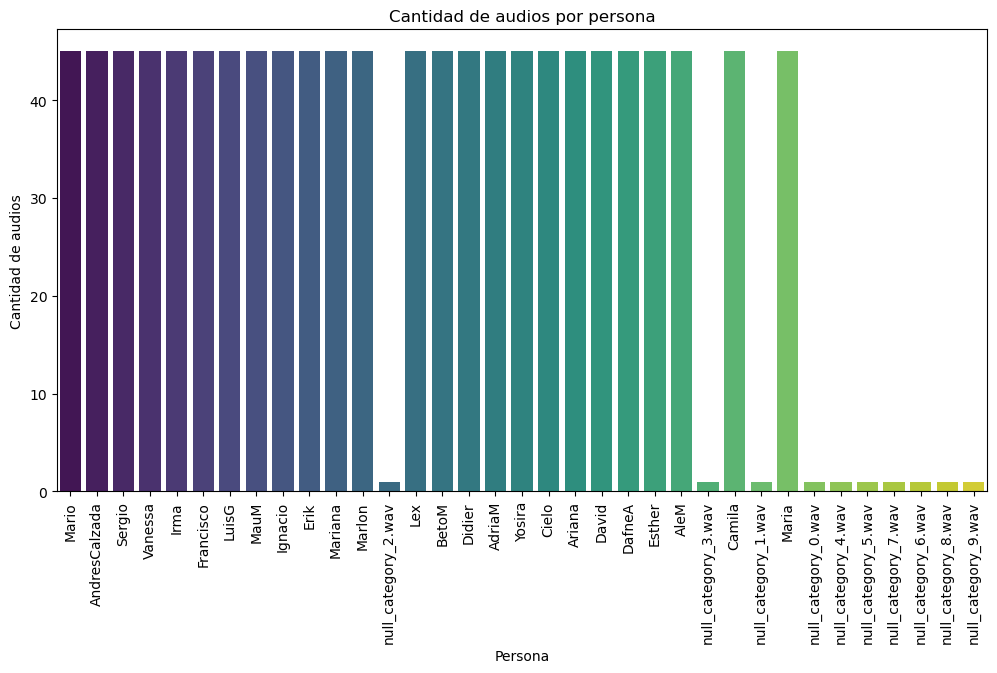

In [60]:
# Contar cantidad de audios por persona
def count_audios_per_person(audio_folder):
    person_counts = Counter()
    for file in audio_files:
        person_id = file.split("-")[0]  # Extrae "Persona"
        person_counts[person_id] += 1

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(person_counts.keys()), 
            y=list(person_counts.values()), 
            hue=list(person_counts.keys()), 
            palette="viridis", 
            legend=False)
    plt.xlabel("Persona")
    plt.ylabel("Cantidad de audios")
    plt.title("Cantidad de audios por persona")
    plt.xticks(rotation=90)
    plt.show()
count_audios_per_person(AUDIO_FOLDER)

#### 3.2 Información sobre los audios

Duración, cantidad de audios por frase, espectograma, forma de audio y sonido.

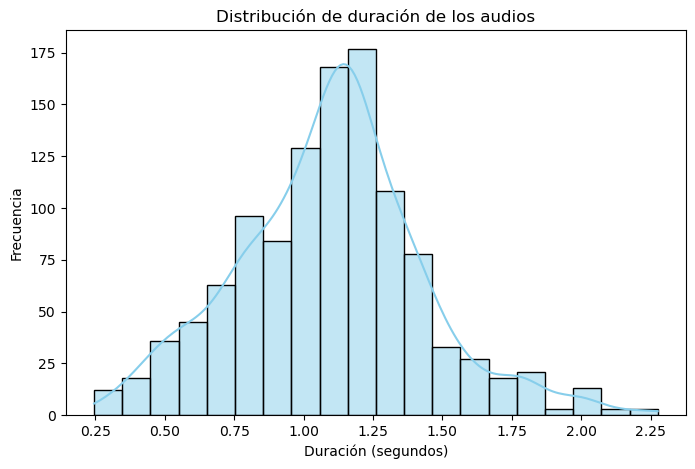

In [63]:
# Distribucion de la duración del audio
def analyze_audio_duration(audio_folder):
    durations = []
    for file in audio_files:
        file_path = os.path.join(audio_folder, file)
        audio, sr = librosa.load(file_path, sr=None)
        durations.append(len(audio) / sr)  # Duración en segundos

    plt.figure(figsize=(8, 5))
    sns.histplot(durations, bins=20, kde=True, color="skyblue")
    plt.xlabel("Duración (segundos)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de duración de los audios")
    plt.show()
analyze_audio_duration(AUDIO_FOLDER)

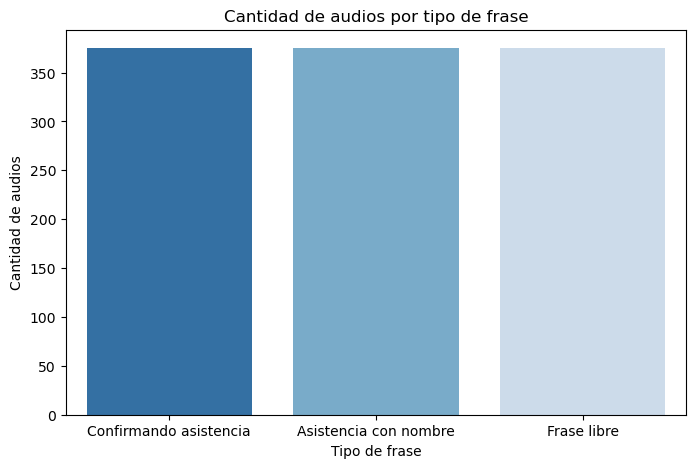

In [65]:
phrase_counts = {"01": 0, "02": 0, "03": 0}
    
for file in audio_files:
    parts = file.split("-")
    if len(parts) > 1:
        phrase_code = parts[1][:2]  # Extrae '01', '02' o '03'
        if phrase_code in phrase_counts:
           phrase_counts[phrase_code] += 1
plt.figure(figsize=(8, 5))
sns.barplot(x=list(phrase_counts.keys()), y=list(phrase_counts.values()), hue=list(phrase_counts.keys()), palette="Blues_r", legend=False)
plt.xlabel("Tipo de frase")
plt.ylabel("Cantidad de audios")
plt.title("Cantidad de audios por tipo de frase")
plt.xticks(ticks=[0, 1, 2], labels=["Confirmando asistencia", "Asistencia con nombre", "Frase libre"])
plt.show()

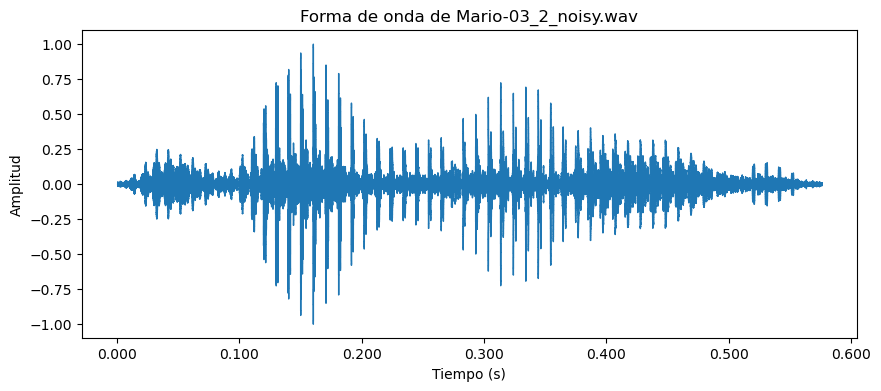

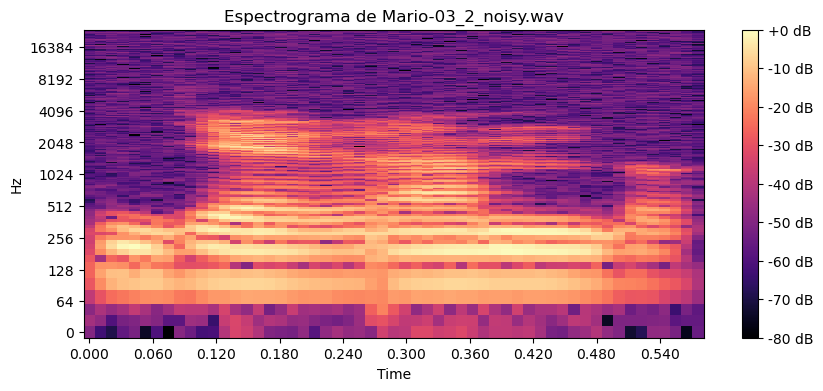

Reproduciendo Mario-03_2_noisy.wav:


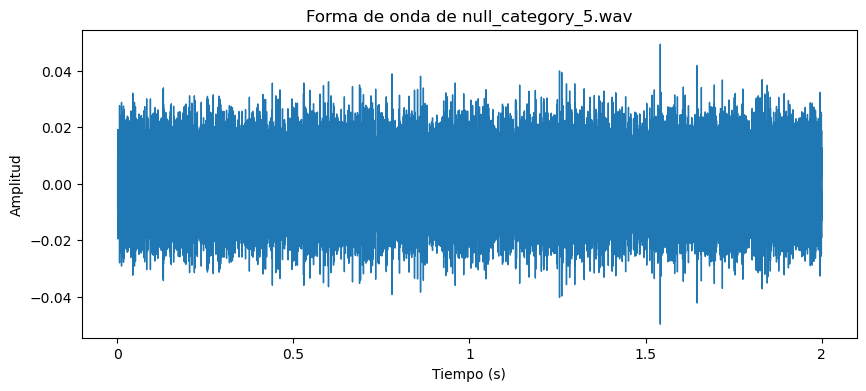

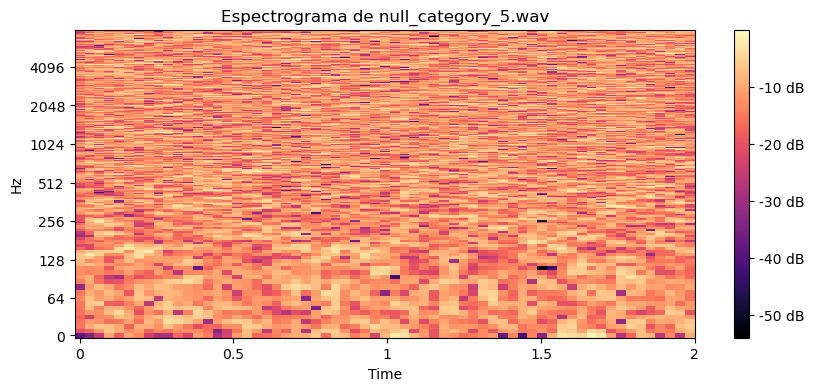

Reproduciendo null_category_5.wav:


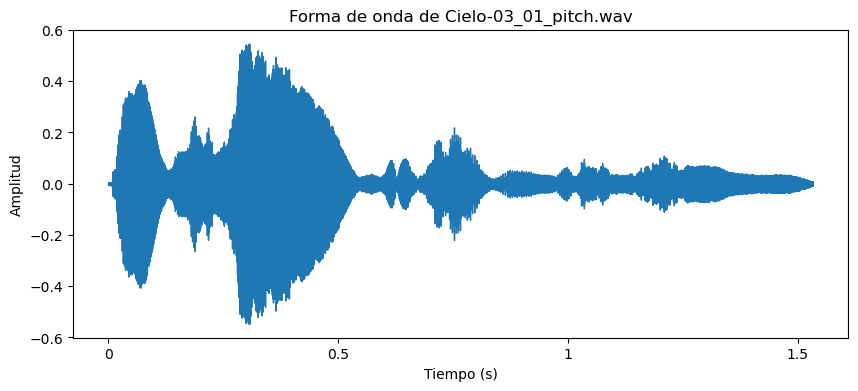

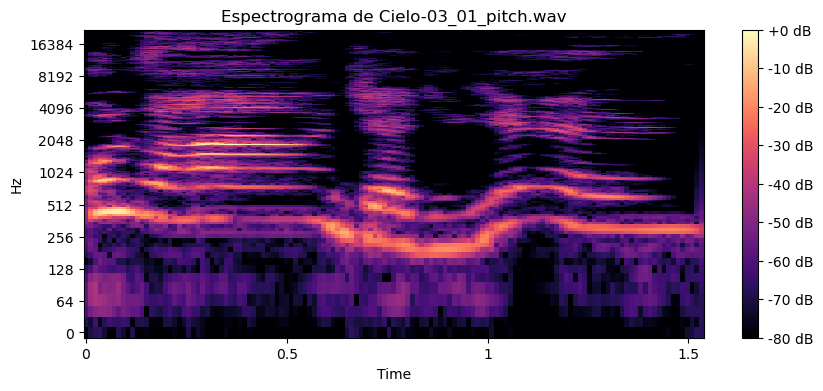

Reproduciendo Cielo-03_01_pitch.wav:


In [70]:
# Visualizar espectrogramas y formas de audio
num_samples = 3
sample_files = np.random.choice(audio_files, num_samples, replace=False)

for file in sample_files:
    file_path = os.path.join(AUDIO_FOLDER, file)
    audio, sr = librosa.load(file_path, sr=None)
    
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"Forma de onda de {file}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()
    
    # Mostrar espectrograma
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Espectrograma de {file}")
    plt.show()
    
    # Reproducir audio
    print(f"Reproduciendo {file}:")
    display(ipd.Audio(file_path))


### 4. Extracción de Características

A continuación se realizara la extracción y selección de características. Para la extracción de características se dividira en 4 secciones: Utilizando la frase 01 (Confirmando mi asistencia), la frase 02 (Asistencia de -persona-), la frase 03 (Frase libre) y utilizando todos los audios. Esto con la intención de observar cual es la mejor frase para utilizar el reconocimiento de voz. 

Para la extracción de características utilizaremos los siguientes métodos:
- MFCCs
- Chroma Features
- Zero-Crossing Rate
- Spectral Features
- RMS Energy

En la selección de las características más relevantes con el fin de reducir el numero de características se utilizaran los métodos:
- Primero eliminar características altamente correlacionadas
- Selección de las mejores características con SelectKBest (ANOVA)
- Utilizar Recursive Feature Elimination (RFE)
- Finalmente visualizamos la importancia con Random Forest

In [73]:
import pandas as pd

#### 4.1 Extraer caracteristicas

In [76]:
# Función para extraer características de un audio
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    # Spectral Features
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))

    # RMS Energy
    rms_energy = np.mean(librosa.feature.rms(y=y))

    # Unir todas las características en un solo vector
    features = np.hstack([mfccs_mean, chroma_mean, zcr_mean, spec_centroid, spec_bandwidth, spec_contrast, rms_energy])
    return features

In [78]:
# Crear DataFrames para cada frase y uno combinado
df1, df2, df3 = [], [], []
df_combined = []

In [80]:
# Recorrer los archivos de audio
for file in tqdm(os.listdir(AUDIO_FOLDER), desc="Extrayendo características"):
    if file.endswith(".wav"):
        file_path = os.path.join(AUDIO_FOLDER, file)
        
        # Identificar si es un audio aumentado o de la clase nula
        if "null_category" in file:
            person = "null_category"
            phrase_id = "null"
        else:
            parts = file.split('-')
            if len(parts) < 2:
                continue
            person = parts[0]  # Nombre de la persona
            phrase_id = parts[1].split('_')[0]  # Tipo de frase (01, 02, 03)

        # Extraer características
        features = extract_features(file_path)
        
        # Crear entrada con etiqueta
        data_entry = np.hstack([features, person])
        
        # Asignar al DataFrame correspondiente
        if phrase_id == "01":
            df1.append(data_entry)
        elif phrase_id == "02":
            df2.append(data_entry)
        elif phrase_id == "03":
            df3.append(data_entry)
        
        # Agregar al conjunto combinado
        df_combined.append(data_entry)

Extrayendo características: 100%|██████████| 1135/1135 [00:37<00:00, 30.66it/s]


In [82]:
# Convertir listas a DataFrames
columns = [f"MFCC_{i}" for i in range(13)] + \
          [f"Chroma_{i}" for i in range(12)] + \
          ["ZCR", "Spec_Centroid", "Spec_Bandwidth", "Spec_Contrast", "RMS_Energy", "Person"]

df1 = pd.DataFrame(df1, columns=columns)
df2 = pd.DataFrame(df2, columns=columns)
df3 = pd.DataFrame(df3, columns=columns)
df_combined = pd.DataFrame(df_combined, columns=columns)

In [84]:
# Guardar los DataFrames
df1.to_csv("features_phrase_01.csv", index=False)
df2.to_csv("features_phrase_02.csv", index=False)
df3.to_csv("features_phrase_03.csv", index=False)
df_combined.to_csv("features_all_phrases.csv", index=False)

print("Extracción de características completada y archivos CSV guardados.")

Extracción de características completada y archivos CSV guardados.


#### 4.2 Visualización de las características

In [87]:
def explore_dataframe(df, title):
    print(f"\n Explorando {title}")
    
    # Mostrar primeras filas
    print("\n Vista previa del DataFrame:")
    print(df.head())

    # Mostrar estadísticas descriptivas
    print("\n Estadísticas descriptivas:")
    print(df.describe())

    # Convertir etiquetas a numéricas para la correlación
    df_numeric = df.drop(columns=["Person"])

    # Heatmap de correlaciones
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_numeric.corr(), cmap="coolwarm", annot=False)
    plt.title(f"Mapa de correlaciones - {title}")
    plt.show()


 Explorando Frase 01 (Confirmando mi asistencia)

 Vista previa del DataFrame:
                MFCC_0              MFCC_1              MFCC_2  \
0  -309.67730712890625   163.6768035888672   11.93171215057373   
1  -234.89454650878906        86.658203125    35.9165153503418   
2   -354.2746887207031  144.04527282714844    5.93995475769043   
3   -328.6885986328125  133.92271423339844  25.816286087036133   
4   -315.9647216796875  108.50930786132812  23.988588333129883   

              MFCC_3              MFCC_4               MFCC_5  \
0  49.57920837402344  20.392362594604492  -12.569884300231934   
1  30.51072120666504    22.1088809967041   24.504037857055664   
2  38.89937210083008  28.597253799438477    2.791661262512207   
3  35.87405014038086   33.01186752319336     9.52474308013916   
4  58.67352294921875   19.67609405517578   12.366803169250488   

                MFCC_6               MFCC_7               MFCC_8  \
0   -9.185052871704102  -22.181177139282227  -15.468462944030762

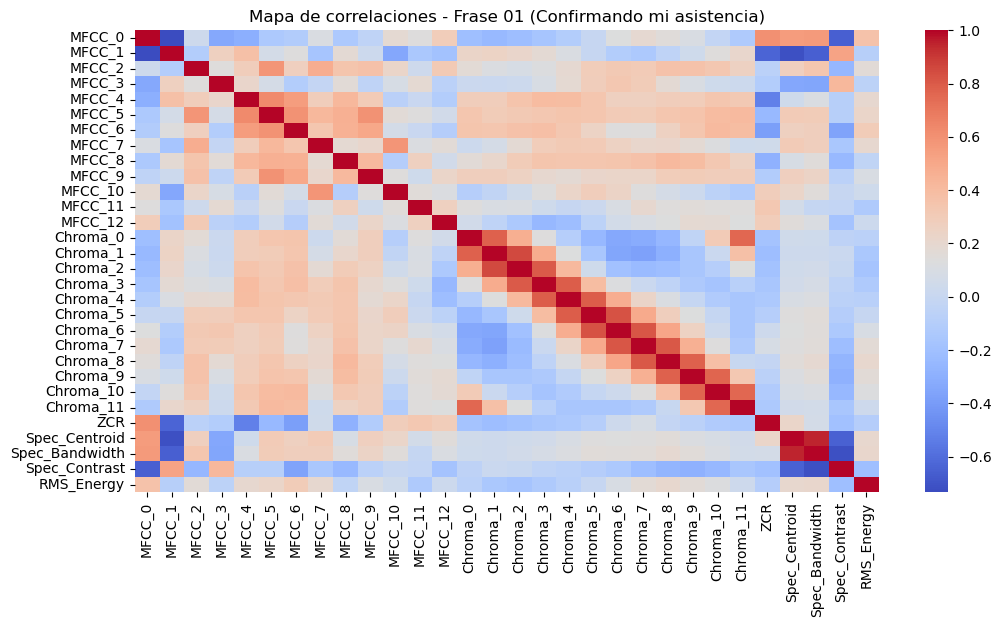

In [89]:
# Explorar los DataFrames generados
explore_dataframe(df1, "Frase 01 (Confirmando mi asistencia)")


 Explorando Frase 02 (Asistencia de -persona-)

 Vista previa del DataFrame:
                MFCC_0              MFCC_1               MFCC_2  \
0  -222.11892700195312    64.8846206665039   10.696322441101074   
1   -357.7194519042969   98.94840240478516   31.023109436035156   
2  -250.99876403808594   181.2749481201172  -25.938365936279297   
3   -365.1542053222656   109.4843521118164    7.252702236175537   
4   -386.3158264160156  122.05033874511719   18.268484115600586   

               MFCC_3               MFCC_4                MFCC_5  \
0  16.177335739135742  -1.9701361656188965   -2.1986732482910156   
1  63.282386779785156   24.517213821411133    31.443782806396484   
2   8.425196647644043    31.42152976989746  -0.31570857763290405   
3   60.05071258544922   18.290340423583984    13.564553260803223   
4  27.052867889404297   28.124656677246094    1.0667284727096558   

               MFCC_6               MFCC_7               MFCC_8  \
0  -16.84502410888672  -12.530349731445312 

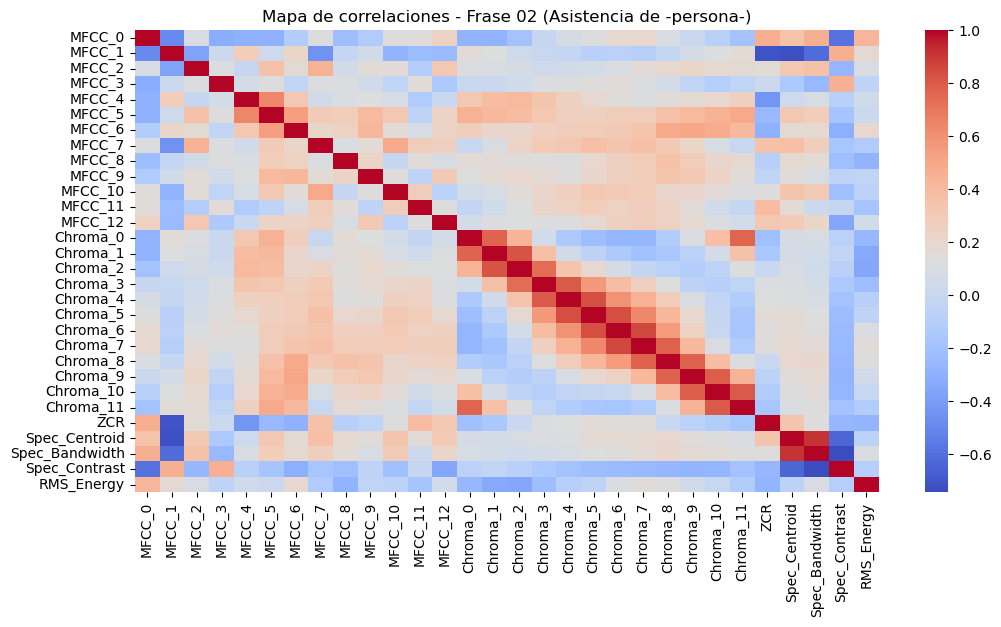

In [91]:
# Frase 2
explore_dataframe(df2, "Frase 02 (Asistencia de -persona-)")


 Explorando Frase 03 (Frase Libre)

 Vista previa del DataFrame:
                MFCC_0              MFCC_1             MFCC_2  \
0          -404.453125     224.26220703125  36.47024154663086   
1  -238.22962951660156   75.66673278808594  20.05015754699707   
2   -316.8077087402344  205.91683959960938  8.283474922180176   
3   -376.4097900390625  136.00115966796875  52.19618225097656   
4   -245.9239044189453    84.6334457397461   39.2642822265625   

               MFCC_3              MFCC_4               MFCC_5  \
0    29.2206974029541  12.488112449645996  -11.361418724060059   
1  23.713516235351562   18.75324058532715    22.21663475036621   
2  14.944550514221191  26.531824111938477    8.969512939453125   
3  46.640193939208984  24.954605102539062   18.411537170410156   
4   45.42017364501953  16.005216598510742    6.728926181793213   

                MFCC_6              MFCC_7              MFCC_8  \
0   2.3243937492370605   16.01524543762207  16.634937286376953   
1   2.44364166

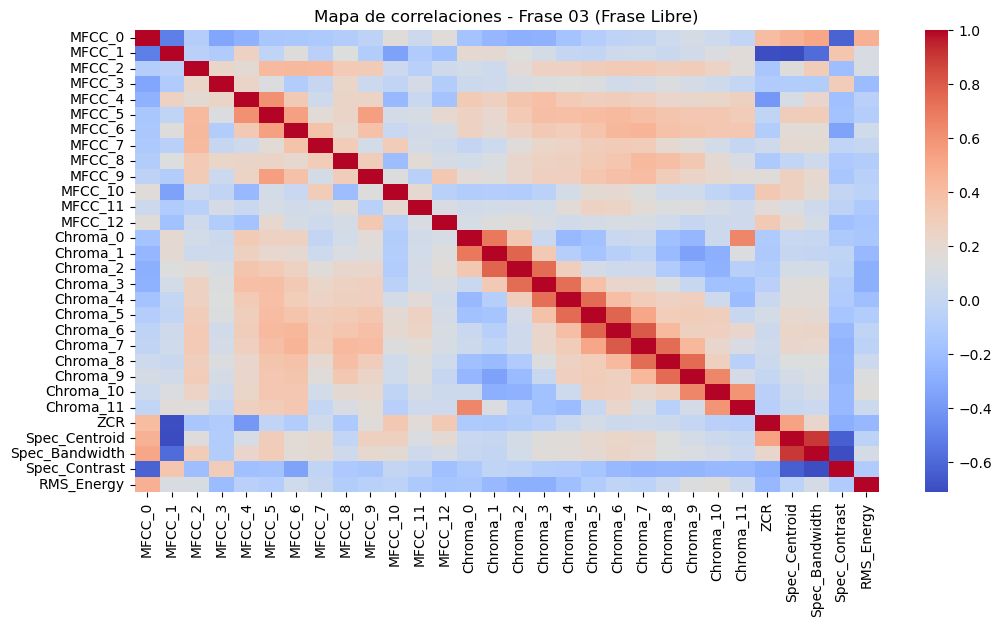

In [93]:
# Frase 3
explore_dataframe(df3, "Frase 03 (Frase Libre)")


 Explorando Todas las frases combinadas

 Vista previa del DataFrame:
                MFCC_0             MFCC_1              MFCC_2  \
0          -404.453125    224.26220703125   36.47024154663086   
1  -309.67730712890625  163.6768035888672   11.93171215057373   
2  -234.89454650878906       86.658203125    35.9165153503418   
3  -222.11892700195312   64.8846206665039  10.696322441101074   
4  -238.22962951660156  75.66673278808594   20.05015754699707   

               MFCC_3               MFCC_4               MFCC_5  \
0    29.2206974029541   12.488112449645996  -11.361418724060059   
1   49.57920837402344   20.392362594604492  -12.569884300231934   
2   30.51072120666504     22.1088809967041   24.504037857055664   
3  16.177335739135742  -1.9701361656188965  -2.1986732482910156   
4  23.713516235351562    18.75324058532715    22.21663475036621   

               MFCC_6               MFCC_7               MFCC_8  \
0  2.3243937492370605    16.01524543762207   16.634937286376953   
1

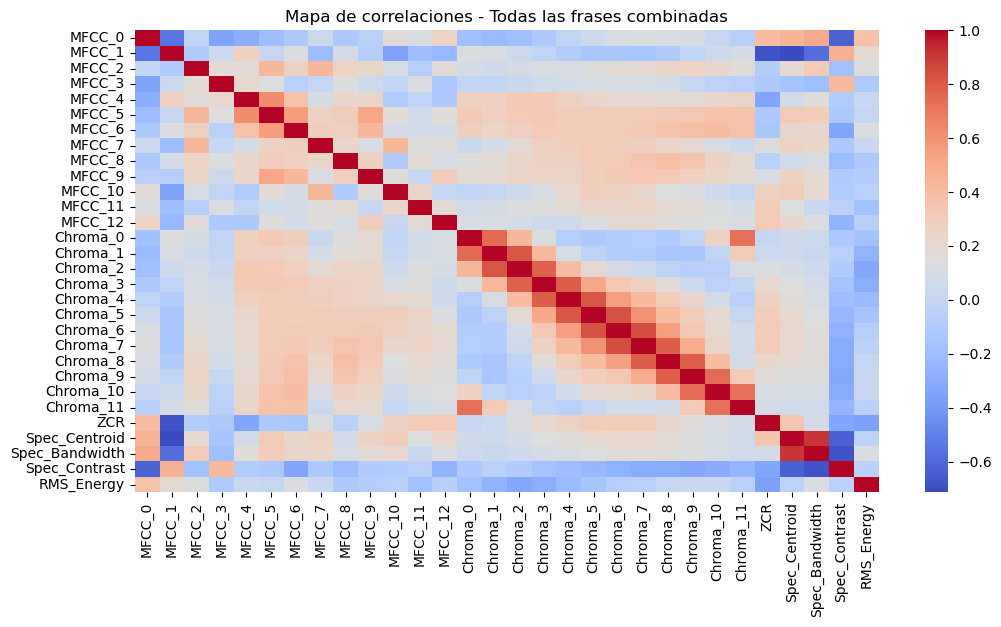

In [95]:
# Todas las frases
explore_dataframe(df_combined, "Todas las frases combinadas")

#### 4.3 Selección de características

In [98]:
# Importamos librerias necesarias
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [100]:
df1 = pd.read_csv("features_phrase_01.csv")
df2 = pd.read_csv("features_phrase_02.csv")
df3 = pd.read_csv("features_phrase_03.csv")
df_combined = pd.read_csv("features_all_phrases.csv")


In [102]:
# Función para Selección de Características

def select_features(df, title, n_features=10):
    print(f"\n Selección de características para {title}")

    # Separar características y etiquetas
    X = df.drop(columns=["Person"])
    y = df["Person"]

    # Codificar las etiquetas (Person) a valores numéricos
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Eliminar características altamente correlacionadas
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]
    print(f" Eliminando {len(high_corr_features)} características altamente correlacionadas...")
    X_filtered = X.drop(columns=high_corr_features)

    # Selección con SelectKBest (ANOVA)
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_best = selector.fit_transform(X_filtered, y_encoded)
    selected_features = X_filtered.columns[selector.get_support()]
    print(f" Seleccionando las {n_features} mejores características con ANOVA...")

    # RFE con RandomForest
    model = RandomForestClassifier()
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_filtered, y_encoded)
    rfe_features = X_filtered.columns[rfe.support_]
    print(f" Selección con RFE completada. Características seleccionadas: {list(rfe_features)}")

    # Visualizar Importancia de Características
    model.fit(X_filtered, y_encoded)
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": X_filtered.columns, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", hue="Feature", data=feature_importance_df.head(n_features), palette="viridis", legend=False)
    plt.title(f"Importancia de características - {title}")
    plt.show()

    # Mantener las etiquetas de "Person" en el DataFrame reducido
    X_selected = X_filtered[selected_features].copy()
    X_selected["Person"] = y  # Agregar etiquetas nuevamente

    return X_selected  # Retorna el conjunto de datos reducido con etiquetas



 Selección de características para Frase 01
 Eliminando 1 características altamente correlacionadas...
 Seleccionando las 10 mejores características con ANOVA...
 Selección con RFE completada. Características seleccionadas: ['MFCC_2', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'Chroma_3', 'Chroma_6', 'ZCR']


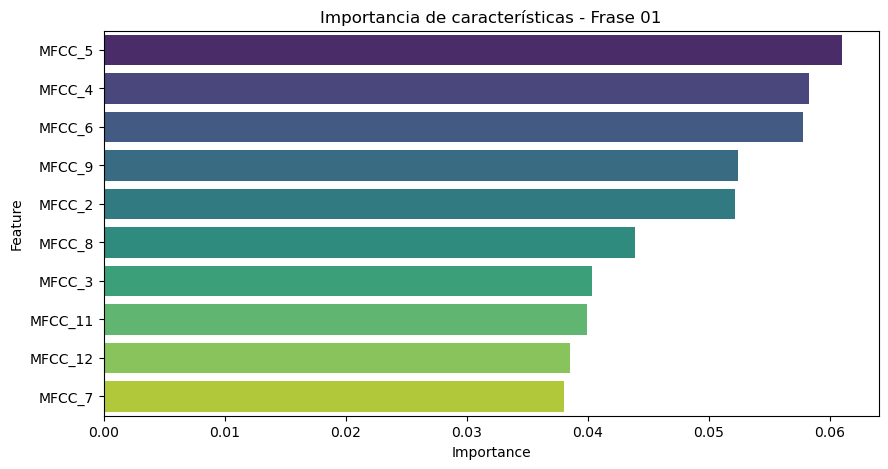

In [104]:
# Aplicar Selección de Características a los DataFrames

df1_selected = select_features(df1, "Frase 01")


 Selección de características para Frase 02
 Eliminando 1 características altamente correlacionadas...
 Seleccionando las 10 mejores características con ANOVA...
 Selección con RFE completada. Características seleccionadas: ['MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'Chroma_5', 'Chroma_11', 'ZCR']


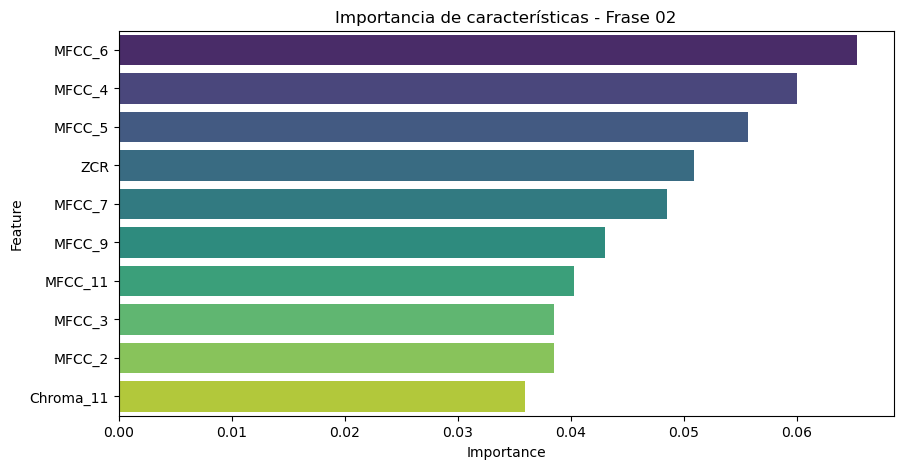

In [105]:
df2_selected = select_features(df2, "Frase 02")


 Selección de características para Frase 03
 Eliminando 1 características altamente correlacionadas...
 Seleccionando las 10 mejores características con ANOVA...
 Selección con RFE completada. Características seleccionadas: ['MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_11', 'Chroma_7', 'ZCR']


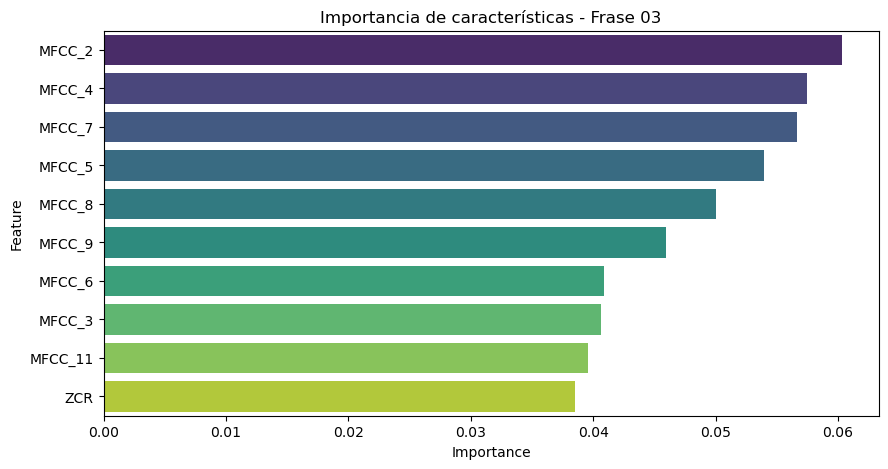

In [108]:
df3_selected = select_features(df3, "Frase 03")


 Selección de características para Todas las frases combinadas
 Eliminando 1 características altamente correlacionadas...
 Seleccionando las 10 mejores características con ANOVA...
 Selección con RFE completada. Características seleccionadas: ['MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_11', 'Chroma_0', 'Chroma_6', 'ZCR']


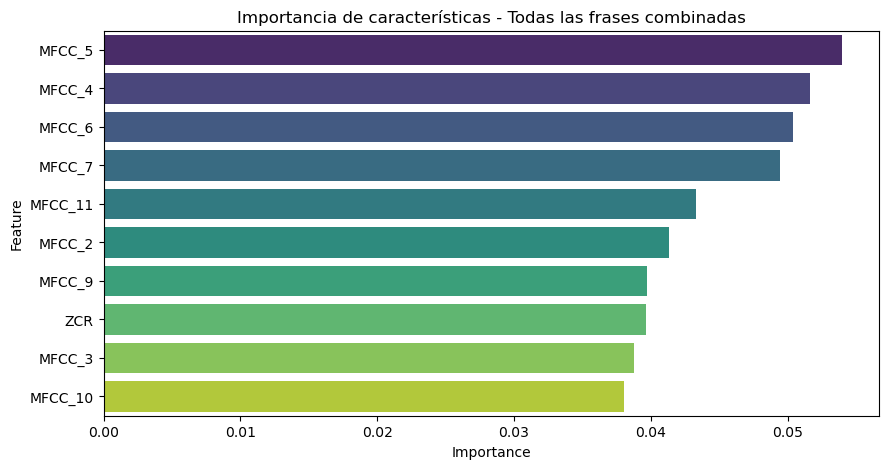

In [110]:
df_combined_selected = select_features(df_combined, "Todas las frases combinadas")

In [112]:
# Guardar los nuevos DataFrames reducidos
df1_selected.to_csv("features_phrase_01_selected.csv", index=False)
df2_selected.to_csv("features_phrase_02_selected.csv", index=False)
df3_selected.to_csv("features_phrase_03_selected.csv", index=False)
df_combined_selected.to_csv("features_all_phrases_selected.csv", index=False)

print("\n Selección de características completada. Archivos CSV guardados con características reducidas.")


 Selección de características completada. Archivos CSV guardados con características reducidas.


In [204]:
# Guardamos las características que se seleccionaron para el mejor modelo
selected_features = df2_selected.drop(columns=["Person"]).columns.tolist()
joblib.dump(selected_features, "selected_features_phrase_02.pkl")

['selected_features_phrase_02.pkl']

#### 4.4 Exploración de las características seleccionadas

In [115]:
# Cargar los DataFrames reducidos

df1_selected = pd.read_csv("features_phrase_01_selected.csv")
df2_selected = pd.read_csv("features_phrase_02_selected.csv")
df3_selected = pd.read_csv("features_phrase_03_selected.csv")
df_combined_selected = pd.read_csv("features_all_phrases_selected.csv")

In [117]:
# Eliminar la etiqueta categórica para la exploración
df1_selected_NC = df1_selected.drop(columns=["Person"], errors="ignore")
df2_selected_NC = df2_selected.drop(columns=["Person"], errors="ignore")
df3_selected_NC = df3_selected.drop(columns=["Person"], errors="ignore")
df_combined_selected_NC = df_combined_selected.drop(columns=["Person"], errors="ignore")

In [119]:
# Función para explorar los DataFrames

def explore_selected_dataframe(df, title):
    print(f"\n Explorando {title}")

    # Mostrar primeras filas
    print("\n Vista previa del DataFrame:")
    print(df.head())

    # Mostrar estadísticas descriptivas
    print("\n Estadísticas descriptivas:")
    print(df.describe())

    # Heatmap de correlaciones
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
    plt.title(f"Mapa de correlaciones - {title}")
    plt.show()


 Explorando Frase 01 (Reducido)

 Vista previa del DataFrame:
      MFCC_2     MFCC_4     MFCC_5     MFCC_6     MFCC_7     MFCC_8  \
0  11.931712  20.392363 -12.569884  -9.185053 -22.181177 -15.468463   
1  35.916515  22.108881  24.504038   9.653809   2.040479  -5.428279   
2   5.939955  28.597254   2.791661  -8.914304 -27.713932  -8.552114   
3  25.816286  33.011868   9.524743 -15.784515 -16.702297  -7.565488   
4  23.988588  19.676094  12.366803 -32.183514 -11.395405 -11.703522   

      MFCC_9    MFCC_10  Chroma_3       ZCR  
0 -18.096764 -22.680515  0.372898  0.057849  
1  -5.480868  -4.311018  0.441152  0.090155  
2  -2.663923 -17.662279  0.169842  0.041512  
3 -10.083037 -16.490986  0.549724  0.064481  
4 -23.598488  -7.948146  0.252043  0.155773  

 Estadísticas descriptivas:
           MFCC_2      MFCC_4      MFCC_5      MFCC_6      MFCC_7      MFCC_8  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean    22.842710   17.413998    7.211060  

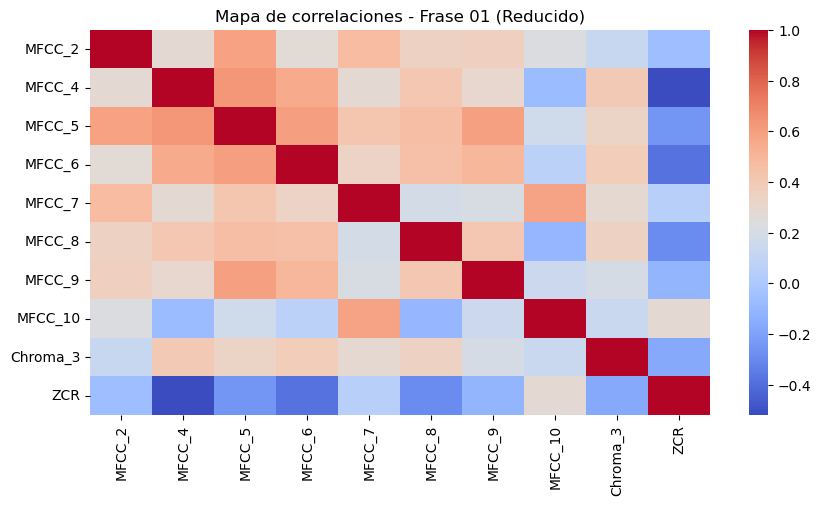

In [121]:
# Explorar los DataFrames reducidos

explore_selected_dataframe(df1_selected_NC, "Frase 01 (Reducido)")


 Explorando Frase 02 (Reducido)

 Vista previa del DataFrame:
      MFCC_4     MFCC_5     MFCC_6     MFCC_7     MFCC_9    MFCC_11  Chroma_5  \
0  -1.970136  -2.198673 -16.845024 -12.530350  -9.973928  -1.982451  0.236974   
1  24.517214  31.443783  -5.315425   1.549930  -5.662252 -10.624568  0.361216   
2  31.421530  -0.315709  -2.422952  -9.544968 -16.540131   1.706101  0.326325   
3  18.290340  13.564553  26.421968 -16.111349  -6.823095   2.136287  0.270071   
4  28.124657   1.066728  -7.850935 -17.633610 -13.828332 -18.029539  0.034604   

   Chroma_6  Chroma_11       ZCR  
0  0.314951   0.376458  0.123904  
1  0.475800   0.421090  0.096971  
2  0.301584   0.285206  0.050240  
3  0.317659   0.445042  0.074728  
4  0.063662   0.676526  0.024098  

 Estadísticas descriptivas:
           MFCC_4      MFCC_5      MFCC_6      MFCC_7      MFCC_9     MFCC_11  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean    15.243444    6.121377   -6.109229  -12.03

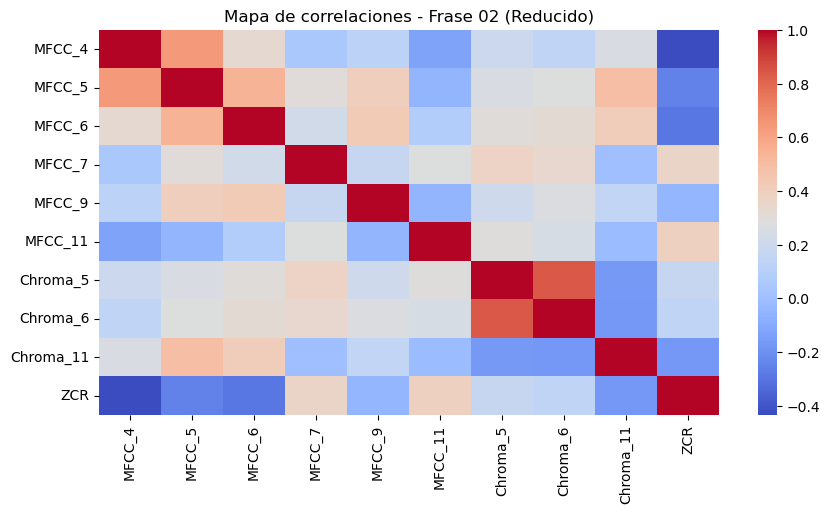

In [123]:
explore_selected_dataframe(df2_selected_NC, "Frase 02 (Reducido)")


 Explorando Frase 03 (Reducido)

 Vista previa del DataFrame:
      MFCC_2     MFCC_4     MFCC_5     MFCC_6     MFCC_7     MFCC_8  \
0  36.470242  12.488112 -11.361419   2.324394  16.015245  16.634937   
1  20.050158  18.753241  22.216635   2.443642  -2.411968   0.317114   
2   8.283475  26.531824   8.969513 -15.918549 -27.178738 -13.737183   
3  52.196182  24.954605  18.411537 -11.086009   1.852335   0.952511   
4  39.264282  16.005217   6.728926   8.107496  -8.349399   0.126004   

      MFCC_9  Chroma_6  Chroma_7       ZCR  
0 -22.286531  0.327035  0.284880  0.021729  
1  -5.771026  0.430988  0.410232  0.098658  
2 -15.497133  0.301153  0.261097  0.032362  
3  -7.945002  0.288137  0.271239  0.053106  
4   0.160045  0.442745  0.620952  0.093468  

 Estadísticas descriptivas:
           MFCC_2      MFCC_4      MFCC_5      MFCC_6      MFCC_7      MFCC_8  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean    17.388151   11.542086    1.480861   -9.60

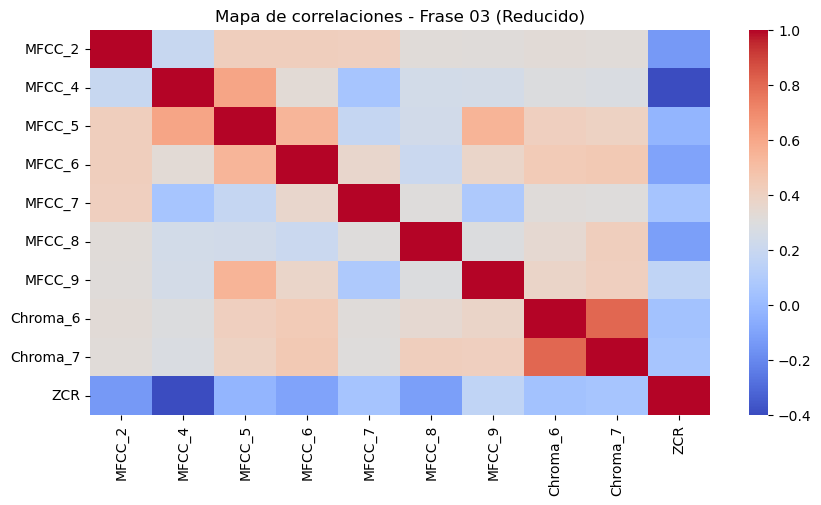

In [125]:
explore_selected_dataframe(df3_selected_NC, "Frase 03 (Reducido)")


 Explorando Todas las frases combinadas (Reducido)

 Vista previa del DataFrame:
      MFCC_4     MFCC_5     MFCC_6     MFCC_7     MFCC_8     MFCC_9  Chroma_5  \
0  12.488112 -11.361419   2.324394  16.015245  16.634937 -22.286531  0.507445   
1  20.392363 -12.569884  -9.185053 -22.181177 -15.468463 -18.096764  0.286369   
2  22.108881  24.504038   9.653809   2.040479  -5.428279  -5.480868  0.447415   
3  -1.970136  -2.198673 -16.845024 -12.530350 -13.690115  -9.973928  0.236974   
4  18.753241  22.216635   2.443642  -2.411968   0.317114  -5.771026  0.531862   

   Chroma_6  Chroma_7       ZCR  
0  0.327035  0.284880  0.021729  
1  0.301761  0.231151  0.057849  
2  0.502582  0.615008  0.090155  
3  0.314951  0.338954  0.123904  
4  0.430988  0.410232  0.098658  

 Estadísticas descriptivas:
            MFCC_4       MFCC_5       MFCC_6       MFCC_7       MFCC_8  \
count  1135.000000  1135.000000  1135.000000  1135.000000  1135.000000   
mean     14.603133     4.891411    -7.560416    -9

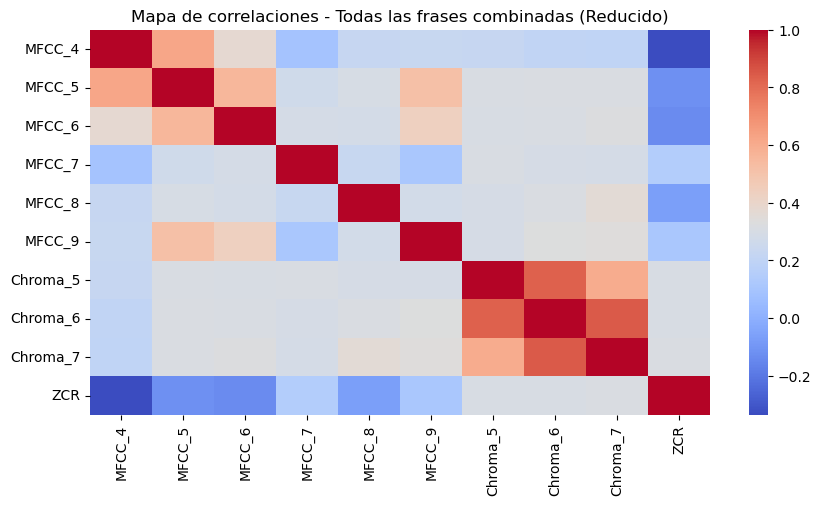

In [127]:
explore_selected_dataframe(df_combined_selected_NC, "Todas las frases combinadas (Reducido)")

### 5. Construcción y evaluación de Modelos

A continuación, se entrenan 5 modelos:
- Regresión Logistica
- Random Forest
- SVM
- KNN Vecinos

Cada modelo se evalua 4 veces, utilizando cada frase (Frase-01, Frase-02 y Frase-03) y una combinación de todas las frases.

#### 5.1 Importamos librerias para los modelos

In [162]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#### 5.2 Iniciámos el entrenamiento

In [165]:
# Cargar los dataframes optimizados
df1 = pd.read_csv("features_phrase_01_selected.csv")
df2 = pd.read_csv("features_phrase_02_selected.csv")
df3 = pd.read_csv("features_phrase_03_selected.csv")
df_combined = pd.read_csv("features_all_phrases_selected.csv")

# Crear un DataFrame vacío para almacenar los resultados
results_df = pd.DataFrame(columns=["Frase", "Modelo", "Accuracy Media", "Accuracy Std"])

In [252]:
# Función para entrenar y evaluar modelos
def train_and_evaluate_models(df, phrase_name):
    print(f"\n Entrenando modelos para: {phrase_name}")

    # Separar características y etiquetas
    X = df.drop(columns=["Person"])
    y = df["Person"]

    # Codificar etiquetas
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Normalizar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Definir modelos
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(kernel="linear"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
    }

    # Evaluar cada modelo con validación cruzada
    for model_name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=5, scoring="accuracy")
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)

        # Agregar resultados al DataFrame
        results_df.loc[len(results_df)] = [phrase_name, model_name, mean_acc, std_acc]


    # Entrenar el mejor modelo (SVM) Despues de un analisis de resultados, se llego a la conclusión de que este era el mejor modelo por su
    # precisión
    best_model = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    best_model.fit(X_train, y_train)

    # Predicciones y análisis de errores
    y_pred = best_model.predict(X_test)

    # Obtener las clases presentes en y_test y y_pred
    unique_classes = np.unique(np.concatenate((y_test, y_pred)))
    filtered_target_names = [label_encoder.classes_[i] for i in unique_classes]

    print("\n Reporte de clasificación:")
    print(classification_report(y_test, y_pred, labels=unique_classes, target_names=filtered_target_names))


    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=filtered_target_names, 
                yticklabels=filtered_target_names)
    plt.title(f"Matriz de Confusión - {phrase_name}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # Identificar audios mal clasificados
    misclassified_indices = np.where(y_test != y_pred)[0]
    if len(misclassified_indices) > 0:
        print("\n Audios mal clasificados:")
        for idx in misclassified_indices[:10]:  # Mostrar hasta 10 errores
            true_label = label_encoder.inverse_transform([y_test[idx]])[0]
            predicted_label = label_encoder.inverse_transform([y_pred[idx]])[0]
            print(f"Audio {idx}: {true_label} ➝ {predicted_label}")


 Entrenando modelos para: Frase 01


/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_


 Clasificación Report:
               precision    recall  f1-score   support

       AdriaM       1.00      1.00      1.00         5
         AleM       1.00      1.00      1.00         3
AndresCalzada       1.00      0.75      0.86         4
       Ariana       1.00      1.00      1.00         1
        BetoM       1.00      1.00      1.00         3
       Camila       0.00      0.00      0.00         0
        Cielo       1.00      1.00      1.00         3
       DafneA       0.80      0.80      0.80         5
        David       1.00      1.00      1.00         5
       Didier       1.00      1.00      1.00         2
         Erik       1.00      1.00      1.00         2
       Esther       1.00      1.00      1.00         2
    Francisco       1.00      0.50      0.67         2
      Ignacio       1.00      1.00      1.00         1
         Irma       1.00      1.00      1.00         3
          Lex       1.00      1.00      1.00         4
        LuisG       1.00      1.00      

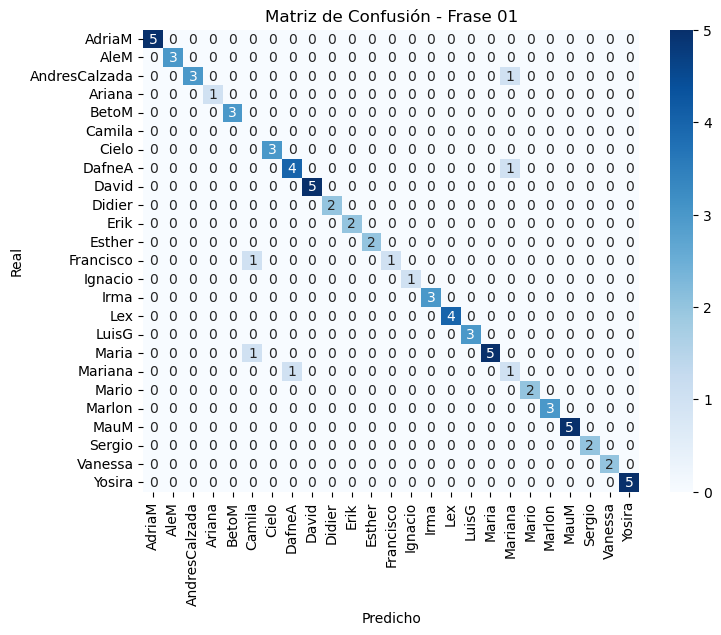


 Audios mal clasificados:
Audio 3: DafneA ➝ Mariana
Audio 9: Maria ➝ Camila
Audio 10: Francisco ➝ Camila
Audio 16: AndresCalzada ➝ Mariana
Audio 19: Mariana ➝ DafneA


In [169]:
# Ejecutar el entrenamiento para cada conjunto de datos
train_and_evaluate_models(df1, "Frase 01")


 Entrenando modelos para: Frase 02


/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_


 Clasificación Report:
               precision    recall  f1-score   support

       AdriaM       1.00      1.00      1.00         2
         AleM       1.00      1.00      1.00         3
AndresCalzada       1.00      1.00      1.00         4
       Ariana       1.00      1.00      1.00         4
       Camila       1.00      1.00      1.00         3
       DafneA       0.83      1.00      0.91         5
        David       1.00      1.00      1.00         3
       Didier       1.00      1.00      1.00         2
         Erik       1.00      1.00      1.00         3
       Esther       0.86      1.00      0.92         6
    Francisco       1.00      1.00      1.00         3
      Ignacio       1.00      1.00      1.00         3
         Irma       0.67      0.80      0.73         5
          Lex       1.00      1.00      1.00         1
        LuisG       0.71      1.00      0.83         5
        Maria       1.00      1.00      1.00         1
      Mariana       1.00      0.50      

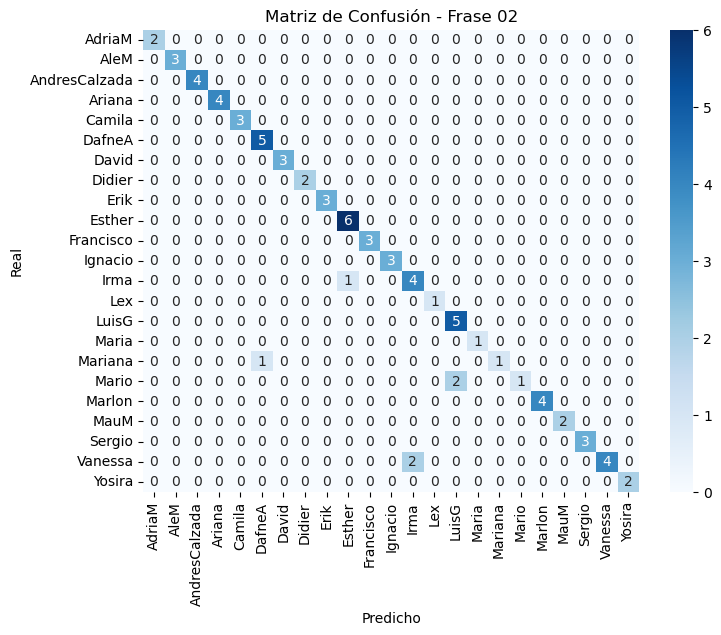


 Audios mal clasificados:
Audio 11: Vanessa ➝ Irma
Audio 35: Vanessa ➝ Irma
Audio 37: Mariana ➝ DafneA
Audio 52: Mario ➝ LuisG
Audio 53: Irma ➝ Esther
Audio 56: Mario ➝ LuisG


In [171]:
train_and_evaluate_models(df2, "Frase 02")


 Entrenando modelos para: Frase 03


/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_


 Clasificación Report:
               precision    recall  f1-score   support

       AdriaM       0.50      0.40      0.44         5
         AleM       0.60      0.75      0.67         4
AndresCalzada       0.67      1.00      0.80         2
       Ariana       1.00      0.67      0.80         3
        BetoM       1.00      1.00      1.00         2
       Camila       1.00      1.00      1.00         2
        Cielo       0.75      1.00      0.86         3
       DafneA       0.83      1.00      0.91         5
        David       1.00      0.50      0.67         4
       Didier       1.00      1.00      1.00         4
         Erik       1.00      1.00      1.00         1
       Esther       0.00      0.00      0.00         0
    Francisco       1.00      1.00      1.00         4
      Ignacio       0.50      0.25      0.33         4
          Lex       1.00      1.00      1.00         3
        LuisG       0.67      1.00      0.80         2
        Maria       0.80      1.00      

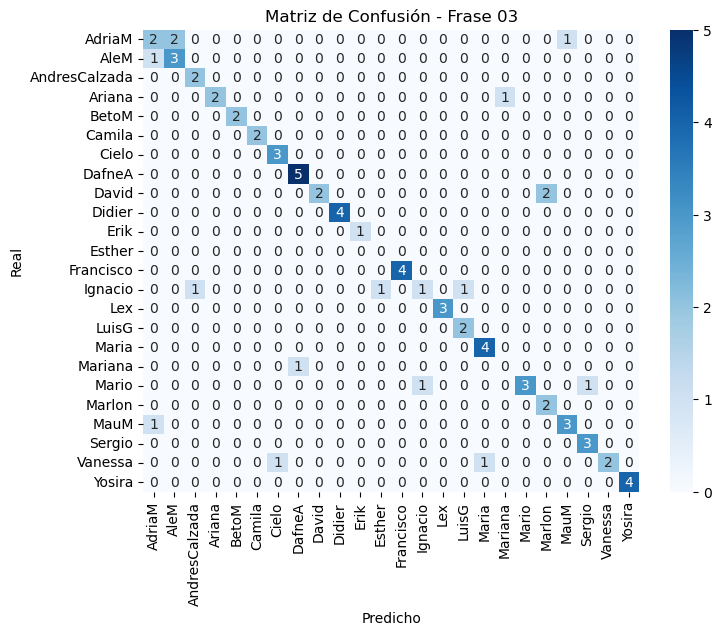


 Audios mal clasificados:
Audio 5: Mario ➝ Sergio
Audio 6: Ariana ➝ Mariana
Audio 14: David ➝ Marlon
Audio 15: Vanessa ➝ Maria
Audio 16: Mario ➝ Ignacio
Audio 17: MauM ➝ AdriaM
Audio 19: David ➝ Marlon
Audio 23: Vanessa ➝ Cielo
Audio 24: Ignacio ➝ AndresCalzada
Audio 29: AleM ➝ AdriaM


In [173]:
train_and_evaluate_models(df3, "Frase 03")


 Entrenando modelos para: Todas las frases combinadas


/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_


 Clasificación Report:
               precision    recall  f1-score   support

       AdriaM       0.78      0.64      0.70        11
         AleM       0.79      1.00      0.88        11
AndresCalzada       0.60      0.55      0.57        11
       Ariana       0.89      0.80      0.84        10
        BetoM       0.50      0.57      0.53         7
       Camila       0.73      0.57      0.64        14
        Cielo       0.83      0.67      0.74        15
       DafneA       0.62      0.83      0.71         6
        David       0.75      1.00      0.86         6
       Didier       1.00      1.00      1.00         8
         Erik       0.77      0.83      0.80        12
       Esther       0.58      0.78      0.67         9
    Francisco       0.50      0.62      0.56         8
      Ignacio       0.75      0.86      0.80         7
         Irma       0.75      0.90      0.82        10
          Lex       0.75      0.86      0.80         7
        LuisG       1.00      0.58      

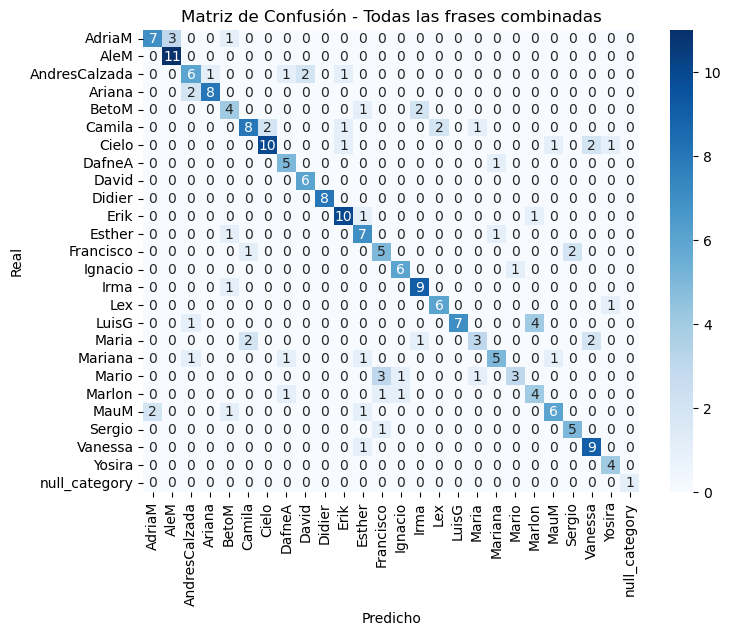


 Audios mal clasificados:
Audio 1: AndresCalzada ➝ David
Audio 3: Cielo ➝ Vanessa
Audio 4: Mariana ➝ Esther
Audio 5: AdriaM ➝ AleM
Audio 14: Ariana ➝ AndresCalzada
Audio 20: Mariana ➝ DafneA
Audio 22: Maria ➝ Vanessa
Audio 25: Francisco ➝ Sergio
Audio 30: Camila ➝ Maria
Audio 32: Esther ➝ Mariana


In [175]:
train_and_evaluate_models(df_combined, "Todas las frases combinadas")

#### 5.3 Visualización General de los resultados obtenidos con cada modelo en cada una de las frases.

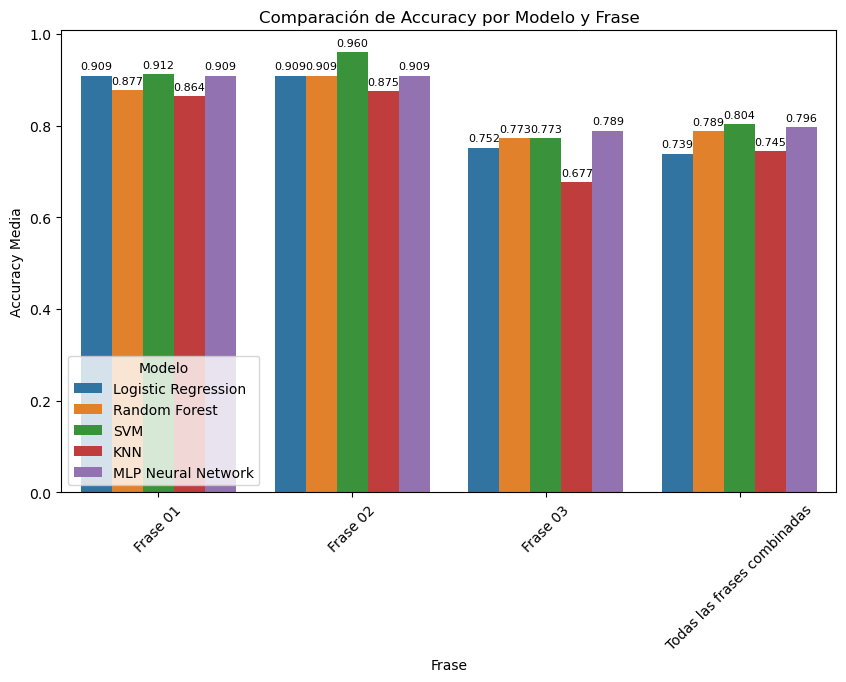

In [178]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df, x="Frase", y="Accuracy Media", hue="Modelo", errorbar=None)

# Agregar etiquetas con valores en la cima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=8, padding=3)

# Personalizar el gráfico
plt.title("Comparación de Accuracy por Modelo y Frase")
plt.ylabel("Accuracy Media")
plt.xlabel("Frase")
plt.xticks(rotation=45)
plt.legend(title="Modelo")

# Mostrar gráfico
plt.show()

En los 5 modelos, el que mejores resultados obtuve fue SVM utilizando la frase 02 correspondiente a "Asistencia de -Persona'", en comparación con los otros modelos evaluados con otras frases.

### 6. Validación Externa

En esta sección, se selecciono la frase 2 para realizar la validación externa utilizando SVM, ya que del analisis anterior, fue el que mejor resultados mostro.

#### 6.1 Realizamos los ajustes para el modelo entrenado

In [221]:
# Cargar el DataFrame optimizado para la Frase 02
df2 = pd.read_csv("features_phrase_02_selected.csv")

# Separar características y etiquetas
X = df2.drop(columns=["Person"])
y = df2["Person"]

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### 6.2 Entrenamos y guardamos el modelo SVM

In [224]:
# Definir el mejor modelo (SVM)
best_model = SVC(kernel="linear", probability=True)

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar el modelo SVM
best_model.fit(X_train, y_train)

# Guardar el modelo, el escalador y el label encoder
joblib.dump(best_model, "svm_model_phrase_02.pkl")
joblib.dump(scaler, "scaler_phrase_02.pkl")
joblib.dump(label_encoder, "label_encoder_phrase_02.pkl")

print(" Modelo SVM guardado correctamente como 'svm_model_phrase_02.pkl'.")

 Modelo SVM guardado correctamente como 'svm_model_phrase_02.pkl'.


#### 6.3 Evaluación del modelo


 Clasificación Report:
               precision    recall  f1-score   support

       AdriaM       1.00      1.00      1.00         2
         AleM       1.00      1.00      1.00         3
AndresCalzada       1.00      1.00      1.00         4
       Ariana       1.00      1.00      1.00         4
       Camila       1.00      1.00      1.00         3
       DafneA       0.83      1.00      0.91         5
        David       1.00      1.00      1.00         3
       Didier       1.00      1.00      1.00         2
         Erik       1.00      1.00      1.00         3
       Esther       0.86      1.00      0.92         6
    Francisco       1.00      1.00      1.00         3
      Ignacio       1.00      1.00      1.00         3
         Irma       0.67      0.80      0.73         5
          Lex       1.00      1.00      1.00         1
        LuisG       0.71      1.00      0.83         5
        Maria       1.00      1.00      1.00         1
      Mariana       1.00      0.50      

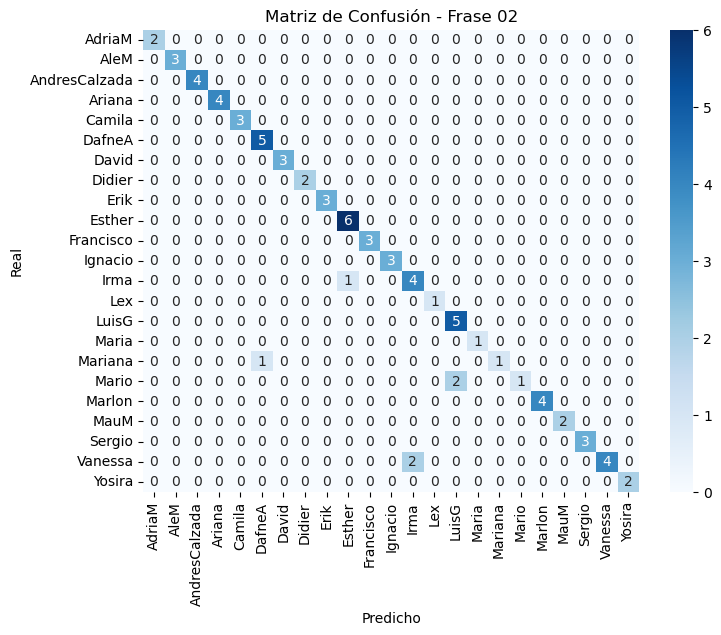

In [227]:
# Predicciones y análisis de errores
y_pred = best_model.predict(X_test)

# Obtener las clases presentes en y_test y y_pred
unique_classes = np.unique(np.concatenate((y_test, y_pred)))
filtered_target_names = [label_encoder.classes_[i] for i in unique_classes]

print("\n Clasificación Report:")
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=filtered_target_names))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=filtered_target_names, 
            yticklabels=filtered_target_names)
plt.title("Matriz de Confusión - Frase 02")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

#### 6.4 Grabamos el nuevo audio para la validación externa

In [231]:
# Librerias para grabar el audio
import sounddevice as sd
import wavio

In [235]:
# Parámetros de grabación
DURATION = 3  # Duración en segundos
SAMPLERATE = 16000  # Frecuencia de muestreo

print("Grabando... Hable ahora.")
audio = sd.rec(int(DURATION * SAMPLERATE), samplerate=SAMPLERATE, channels=1, dtype='int16')
sd.wait()
wavio.write("nuevo_audio.wav", audio, SAMPLERATE, sampwidth=2)
print("Grabación completada: nuevo_audio.wav")

Grabando... Hable ahora.
Grabación completada: nuevo_audio.wav


In [255]:
# Cargar el modelo, el escalador y el label encoder

MODEL_PATH = "svm_model_phrase_02.pkl"
SCALER_PATH = "scaler_phrase_02.pkl"
LABEL_ENCODER_PATH = "label_encoder_phrase_02.pkl"
SELECTED_FEATURES_PATH = "selected_features_phrase_02.pkl"

In [257]:
# Cargamos los modelos
svm_model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
label_encoder = joblib.load(LABEL_ENCODER_PATH)
selected_features = joblib.load(SELECTED_FEATURES_PATH)  # Lista de features seleccionadas

In [259]:
# Función para extraer características del audio
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    
    # Remover silencio
    y_trimmed, _ = librosa.effects.trim(y)
    
    # Extraer características
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y_trimmed, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y_trimmed, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y_trimmed)
    
    # Crear un diccionario con nombres de características consistentes
    feature_dict = {}

    for i in range(mfccs.shape[0]):
        feature_dict[f"MFCC_{i+1}"] = np.mean(mfccs[i])
    
    for i in range(chroma.shape[0]):
        feature_dict[f"Chroma_{i+1}"] = np.mean(chroma[i])

    for i in range(spectral_contrast.shape[0]):
        feature_dict[f"SpectralContrast_{i+1}"] = np.mean(spectral_contrast[i])

    feature_dict["ZCR"] = np.mean(zcr)

    return feature_dict

In [266]:
# Función para preprocesar y hacer predicción
def predict_audio(audio_file):
    print(" Procesando audio:", audio_file)
    
    # Extraer características del audio en forma de diccionario
    feature_dict = extract_features(audio_file)
    
    # Convertir a DataFrame
    features_df = pd.DataFrame([feature_dict])

    # Filtrar solo las características seleccionadas en el entrenamiento
    missing_features = [feat for feat in selected_features if feat not in features_df.columns]

    if missing_features:
        print(f" Advertencia: Faltan las siguientes características: {missing_features}")
        return None

    features_selected = features_df[selected_features]

    # Normalizar con el escalador entrenado
    features_scaled = scaler.transform(features_selected)

    # Realizar predicción
    predicted_label = svm_model.predict(features_scaled)
    predicted_person = label_encoder.inverse_transform(predicted_label)[0]
    
    print(f" Predicción: {predicted_person}")
    return predicted_person

In [268]:
# Finalmente prueba con un nuevo audio
audio_path = "nuevo_audio.wav"
predict_audio(audio_path)

 Procesando audio: nuevo_audio.wav
 Predicción: Mario


'Mario'

### 7. Conclusión

El audio grabado correspondia a Francisco diciendo la frase "Asistencia de Francisco". La predicción fue erronea, es necesario evaluar y profundizar más y de mejor manera la validación externa para identificar el error que cometi junto con los detalles omitidos.